In [3]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
import torch.nn.init as init
from torch.utils.data import DataLoader
import torchvision.ops as ops
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import datasets, transforms


#matplotlib.rcParams['figure.facecolor'] = '#ffffff'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Define the transforms
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomRotation(15),
    #transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
    #transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [9]:

# Far_Block1 - implements a block in a neural network. 

# It takes in the following arguments:
# in_channels: Number of input channels to the block.
# out_channels: Number of output channels from the block.
# avgpool_size: The size of the average pooling layer.
# skip1: A flag variable to control the use of a skip connection in the block.
# num_classes: The number of classes in the classification task.


class Far_Block1(nn.Module):
    def __init__(self, in_channels,out_channels,avgpool_size,skip1,num_classes=10):
        super(Far_Block1,self).__init__()
        
        self.avgpool_size = avgpool_size
        #Spatial Average Pooling
        self.avgpool = nn.AdaptiveAvgPool2d(self.avgpool_size)
        self.skip_v=skip1
        
        self.Linear1=nn.Linear((self.avgpool_size**2)*in_channels,out_channels)
        #self.dropout = nn.Dropout(p=0.1)
        #self.softplus = nn.Softplus()
        self.softmax=nn.Softmax()
        
        #self.lrelu = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        #self.alpha = nn.Parameter(torch.tensor(0.1))
        
        #Convolution Layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            
            #nn.PReLU()
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_channels),
            
            #nn.PReLU()
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=7, padding=3),
            nn.BatchNorm2d(out_channels),
            
            #nn.PReLU()
            nn.ReLU()
        )
        
        # Definition 1x1 skip conv layer
        self.skip_layer=nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1),
                             nn.BatchNorm2d(out_channels))
        
    def forward(self, x):
        #Perform spatial adaptive average pooling of size avgpool_size on the input x.
        a=self.avgpool(x)
        #Flatten the output of the pooling layer
        a=a.view(a.size(0),-1)
        #Apply a linear layer to the flattened output
        a=self.Linear1((a))
        #Apply a softmax activation function
        a=self.softmax(a)
        
        #Apply four convolutional layers to the input x with different kernel sizes, 
        #and Apply batch normalization and ReLU activation functions to the output of each convolutional layer
        out1 = self.conv1(x)
        out2 = self.conv2(x)
        out3 = self.conv3(x)
        #out4 = self.conv4(x)
        
        #If the flag variable skip1 meets the condition, 
        #then it applies a 1x1 conv to the input x and adds it to the output of the four convolutional layers
        #It applies a 1x1 conv layer because in all cases in_channels!=out_channels
        if (self.skip_v+1)%2==0:
            out4=self.skip_layer(x)
            a= a.unsqueeze(-1).unsqueeze(-1)
            output =a* out1 + a* out2+ a* out3+a*out4
        else:
            a= a.unsqueeze(-1).unsqueeze(-1)
            output =a* out1 + a* out2+ a* out3

        return output

# Block_Sequence - defines the sequence of blocks to be used in the neural network. 

# It takes in the following arguments:
# hidden_size1: The number of neurons in the first fully connected layer.
# hidden_size2: The number of neurons in the second fully connected layer.
# avgpool_classifier_size: The size of the average pooling layer to be used before the fully connected layers.

class Block_Sequence(nn.Module):
    def __init__(self,hidden_size1,hidden_size2, avgpool_classifier_size):
        super(Block_Sequence,self).__init__()
        
        self.avgpool_classifier_size = avgpool_classifier_size
        
        #The skip connection is applied to each of the odd blocks with the exception of Block 1
        i=0
        self.block1=Far_Block1(3,14,4,i)
        i+=1
        self.block2=Far_Block1(14,45,4,i)
        i+=1
        self.block3=Far_Block1(45,70,6,i)
        i+=1
        self.block4=Far_Block1(70,100,6,i)
        i+=1
        self.block5=Far_Block1(100,150,8,i)
        
        self.mish=nn.Mish()
        
        self.avgpool_g=nn.AdaptiveAvgPool2d(self.avgpool_classifier_size)
        
        self.linear_c1=nn.Linear((self.avgpool_classifier_size**2)*150,hidden_size1)
        self.bn_c1=nn.BatchNorm1d(hidden_size1)
        self.dp1=nn.Dropout(0.5)
        
        self.linear_c2=nn.Linear(hidden_size1,hidden_size2)
        self.bn_c2=nn.BatchNorm1d(hidden_size2)
        self.dp2=nn.Dropout(0.5)
        
        self.linear_c3=nn.Linear(hidden_size2,10)
    def forward(self,x):
        
        # Apply the five blocks defined in Far_Block1 sequentially to the input x
        block_1=self.block1(x)
        block_2=self.block2(block_1)
        block_3=self.block3(block_2)
        block_4=self.block4(block_3)
        block_5=self.block5(block_4)
        
        # Apply the Mish activation function to the output of the last block.
        block_final=self.mish(block_5)
        # Apply an adaptive average pooling layer of size avgpool_classifier_size to the output of the Mish activation function
        block_final=self.avgpool_g(block_final)
        # Flatten the output of the pooling layer
        block_final=block_final.view(block_final.size(0), -1)
        
        # Apply two fully connected layers with batch normalization and dropout between them
        output=self.linear_c1(block_final)
        output=self.bn_c1(output)
        output=self.dp1(output)
        
        output=self.linear_c2(output)
        output=self.bn_c2(output)
        output=self.dp2(output)
        
        # Applies a final linear layer to produce the output logits
        output=self.linear_c3(output)

        return output

# Create an instance of the Block_Sequence class and assigns it to the variable model
avgpool_classifier_size = 8
model = Block_Sequence(1000,200,
                     avgpool_classifier_size=avgpool_classifier_size
                     ).to(device)




In [10]:
import torch.optim as optim
learning_rate = 0.001
num_epochs = 500
weight_decay = 1e-4

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
    
model.apply(init_weights)

# Instance of the cross-entropy loss function
loss_calc = nn.CrossEntropyLoss()

# Instance of the Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
# The maximum number of epochs (period) for the cosine annealing schedule
# Determines the number of times the learning rate will be decreased and increased again during training
T_max = num_epochs  

# Minimum learning rate value that the scheduler will decrease to
eta_min = 0.00001

# Learning rate scheduler that applies a cosine annealing schedule to gradually decrease the learning rate over time
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

learning_rates=[]
training_acc=[]
training_loss=[]
test_acc=[]
test_loss=[]
learning_rates=[]
for epoch in range(num_epochs):
    # Initialize the running loss, running test loss, running correct predictions, and running total to zero.
    running_loss = 0.0
    running_test_loss = 0.0
    running_corrects=0
    running_total=0
    # Train the model on train dataset
    model.train()
    # Loop through each batch in the training data using the train_loader
    for i, (inputs, targets) in enumerate(train_loader):
        
        # Transfer the inputs and targets to the device 
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Get the batch size from the input tensor
        batch_size = inputs.shape[0]
        
        # Forward pass by passing the inputs through the model
        outputs = model(inputs)
        # Reshape the output tensor to match the target tensor shape
        outputs = outputs.view(batch_size, -1)  
        # Calculate the training loss
        train_loss = loss_calc(outputs, targets)
        
        # Choose index of the maximum value in each output tensor row to predict the class 
        _, predicted = torch.max(outputs.data, 1)
        
        # Count the number of correct predictions and the total number of targets
        running_corrects += (predicted == targets).sum().item()
        running_total += targets.size(0)
        # Zero out the optimizer gradients
        optimizer.zero_grad()
        train_loss.backward() # Backpropagation
        optimizer.step() # Update weights
        #Printing loss for every 100 batches
        running_loss += train_loss.item()
        if (i+1) % 100 == 0:
            loss1=running_loss / 100
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Train Loss: {loss1:.4f}')
            running_loss = 0.0
        
    # Record and Update the learning rate scheduler at the end of the epoch
    learning_rates.append(get_lr(optimizer))
    lr_scheduler.step()
    
    # Model evaluation on test dataset
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # Get the batch size from the input tensor
            batch_size = images.shape[0]
            # Pass the inputs through the model
            outputs = model(images)
            # Reshape the output tensor to match the target tensor shape
            outputs = outputs.view(batch_size, -1)
            # Choose index of the maximum value in each output tensor row to predict the class 
            _, predicted = torch.max(outputs.data, 1)
            total += batch_size 
            correct += (predicted == labels).sum().item()
            test_loss1 = loss_calc(outputs, labels)
            running_test_loss += test_loss1.item()
            loss2=running_test_loss / 100
            running_test_loss = 0.0
        # Calculate and pppend the test accuracy, training accuracy, and training loss for the epoch to lists to plot graphs
        test_acc1=100*(correct/total)
        train_acc1=100 * (running_corrects / running_total)
        test_acc.append(round(test_acc1,2))
        test_loss.append(round(loss2, 2))
        training_acc.append(round(train_acc1,2))
        training_loss.append(round(loss1, 2))
        # Print the test accuracy and training accuracy for the epoch
        print(f'\nAccuracy of the model on the {len(test_loader)} test images: {test_acc1:.2f}%')
        print(f'\nAccuracy of the model on the {len(train_loader)} train images: {train_acc1:.2f}%\n')

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

/tmp/ipykernel_190/219584703.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a=self.softmax(a)


Epoch [1/500], Step [100/782], Train Loss: 2.5857
Epoch [1/500], Step [200/782], Train Loss: 2.2898
Epoch [1/500], Step [300/782], Train Loss: 2.1726
Epoch [1/500], Step [400/782], Train Loss: 2.0724
Epoch [1/500], Step [500/782], Train Loss: 1.9497
Epoch [1/500], Step [600/782], Train Loss: 1.8242
Epoch [1/500], Step [700/782], Train Loss: 1.7719

Accuracy of the model on the 157 test images: 44.26%

Accuracy of the model on the 782 train images: 30.89%

Epoch [2/500], Step [100/782], Train Loss: 1.6787
Epoch [2/500], Step [200/782], Train Loss: 1.6780
Epoch [2/500], Step [300/782], Train Loss: 1.6352
Epoch [2/500], Step [400/782], Train Loss: 1.5303
Epoch [2/500], Step [500/782], Train Loss: 1.5460
Epoch [2/500], Step [600/782], Train Loss: 1.5057
Epoch [2/500], Step [700/782], Train Loss: 1.4618

Accuracy of the model on the 157 test images: 53.53%

Accuracy of the model on the 782 train images: 45.41%

Epoch [3/500], Step [100/782], Train Loss: 1.3848
Epoch [3/500], Step [200/782],

KeyboardInterrupt: 

# Plotting curves of loss and accuracy

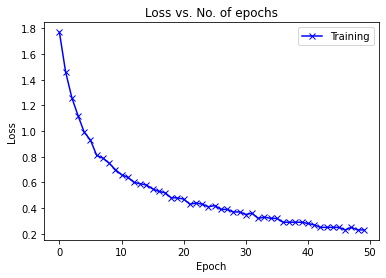

In [20]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

plt.plot(training_loss, '-bx')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Test'])
plt.title('Loss vs. No. of epochs')
plt.show()

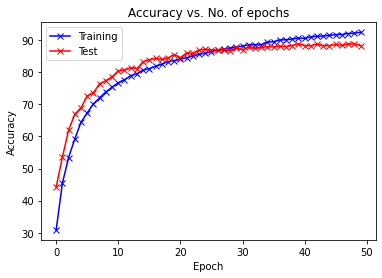

In [17]:
plt.plot(training_acc,'-bx')
plt.plot(test_acc,'-rx')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Test'])
plt.title('Accuracy vs. No. of epochs')
plt.show()

# Plot for learning rate

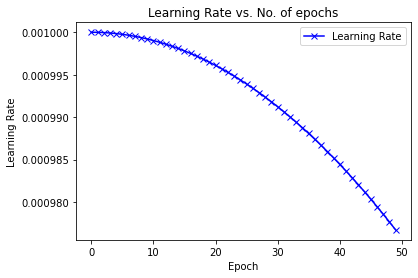

In [21]:
plt.plot(learning_rates, '-bx')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend(['Learning Rate'])
plt.title('Learning Rate vs. No. of epochs')
plt.show()